# Pareto Conditioned networks

Using the modified dam environment (less variance in the inflow), test PCN. This modifications is necessary because PCN expects deterministic transitions.

Also a modification to the original PCN code in morl-baselines is necessary in order to support the continuous actions of the environment:
- continuous_actions is a parameter given to the algorithm
- During training, actions are no longer sampled from a categorical distribution as in the [original paper](https://www.ifaamas.org/Proceedings/aamas2022/pdfs/p1110.pdf). This might hinder exploration...
- The logsoftmax function of the original model is no longer used, instead its output is a single value corresponding to an action
- The loss used in the model is now MSE instead of CE (regression loss vs classification)

In [2]:
from gymnasium.core import Env
import mo_gymnasium as mo_gym
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from morl_baselines.multi_policy.pcn.pcn import PCN
from gymnasium.utils import EzPickle

"""
Helper function to plot pf
"""
def plot_pf(file):
    columns = ["objective_1", "objective_2"]
    df = pd.read_csv(file, usecols=columns)

    plt.plot(df.objective_1, df.objective_2, 'o')
    plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
    plt.ylabel('Deficit in water supply wrt demand')
    plt.show()

#
"""
Scale rewards down to improve PCN's performance
"""
class ScaleReward(gym.RewardWrapper, EzPickle):
    def __init__(self, env: Env):
        super().__init__(env)
        EzPickle.__init__(env)

    def reward(self, reward):
        reward = (reward / 100.0)
        return reward

## First attempt

- Dam inflow: mean = 40.0 and stdev = 1.0 
- Actions capped between [0.0;250.0] (motivation in gpi-ls notebook)
- Scaling factor for desired horizon/return = [0.1, 0.1]
- Hypervolume ref point = [-100, -1000]
- Random noise: X~(0;5.0) Noise is added directly to action.

Also, actions are scaled down with factor 100 because PCN is sensitive to the range of actions...

In [3]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True)

max_return = np.zeros(2)

PCNAgent.train(10000000, env, np.array((-100.0,-1000), dtype=np.float32), num_step_episodes=100,max_return=max_return)

wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/PCN


step 60000 	 return [-82.26866 -92.20118], ([0.54408187 0.6290396 ]) 	 loss 8.769E+03
step 70000 	 return [-75.48533 -85.41563], ([0.5414608  0.70820844]) 	 loss 4.207E+03
step 80000 	 return [-77.73574 -87.67751], ([0.5131005 0.6531166]) 	 loss 3.062E+03
step 90000 	 return [-74.35394 -84.27745], ([0.43701044 0.5445091 ]) 	 loss 2.178E+03
step 100000 	 return [-74.99455 -84.91675], ([0.4653714  0.57966554]) 	 loss 1.479E+03
step 110000 	 return [-70.18356 -80.09503], ([0.36434454 0.5328669 ]) 	 loss 1.028E+03
step 120000 	 return [-72.50139 -82.44405], ([0.43516037 0.56056863]) 	 loss 4.680E+02
step 130000 	 return [-71.97411 -81.9075 ], ([0.4072029 0.5142844]) 	 loss 3.648E+02
step 140000 	 return [-71.36834 -81.30413], ([0.3687014  0.46494484]) 	 loss 2.884E+02
step 150000 	 return [-68.200485 -78.16499 ], ([0.2952062 0.4498387]) 	 loss 2.678E+02
step 160000 	 return [-67.69813  -77.617485], ([0.28538334 0.37763762]) 	 loss 1.725E+02
step 170000 	 return [-68.75096 -78.64478], ([0.3

c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


step 3820000 	 return [-23.941242 -33.672466], ([0.15343323 0.3125724 ]) 	 loss 2.878E+01
step 3830000 	 return [-23.84443  -33.655746], ([0.13369799 0.33795318]) 	 loss 2.727E+01
step 3840000 	 return [-23.89511  -33.689785], ([0.11704697 0.31761557]) 	 loss 2.745E+01
step 3850000 	 return [-23.664959 -33.388313], ([0.17217508 0.30874997]) 	 loss 2.572E+01
step 3860000 	 return [-23.750769 -33.52252 ], ([0.17355207 0.28053993]) 	 loss 2.570E+01
step 3870000 	 return [-23.525791 -33.31076 ], ([0.15543494 0.31101   ]) 	 loss 2.681E+01
step 3880000 	 return [-23.611275 -33.38776 ], ([0.12027194 0.41373432]) 	 loss 2.620E+01
step 3890000 	 return [-23.68736  -33.494637], ([0.23515293 0.220105  ]) 	 loss 2.615E+01
step 3900000 	 return [-23.58222 -33.3204 ], ([0.12913597 0.3709557 ]) 	 loss 2.557E+01
step 3910000 	 return [-23.388151 -33.173153], ([0.16334233 0.29875168]) 	 loss 2.688E+01
step 3920000 	 return [-23.567053 -33.38491 ], ([0.24214691 0.21523795]) 	 loss 2.606E+01
step 3930000

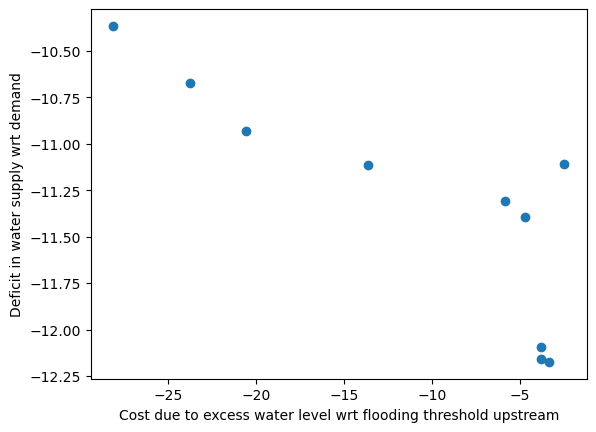

In [4]:
plot_pf('./noise5.csv')

When looking at the returns, there is significant improvement during training. However, the returns are also significantly higher than those of the solution set in the GPI experiments (when scaled back up by factor 100). Learning becomes unstable after around 7000000 steps. => Decay noise (probably)

## Attempt 2

Added noise decay of 0.99 every 100000 steps

# TODO:
- Experiment with scaling factor for desired return
- Experiment with noise: add as parameter, implement decay
- Try to scale the action as in the TD3 policy net (tanh + noise, scale output up)

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.01, 0.01, 0.1), dtype=np.float32), continuous_actions=True, noise=5.0)

max_return = np.zeros(2)

PCNAgent.train(10000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100,max_return=max_return)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/PCN
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  th.tensor(obs).to(self.device),
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in multiply
  ent = np.sum(-np.exp(lp) * lp)
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in exp
  ent = np.sum(-np.exp(lp) * lp)


step 60000 	 return [-79.58982 -89.5748 ], ([0.6480278  0.78957564]) 	 loss 8.624E+03
step 70000 	 return [-75.86534  -85.801414], ([0.64037603 0.8032793 ]) 	 loss 4.304E+03
step 80000 	 return [-82.04873  -91.981476], ([0.70160776 0.8342531 ]) 	 loss 3.142E+03
step 90000 	 return [-72.82013 -82.78728], ([0.58069   0.7266203]) 	 loss 2.105E+03
step 100000 	 return [-73.29544 -83.21858], ([0.5463456 0.6802388]) 	 loss 1.296E+03


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


step 110000 	 return [-76.80146 -86.71199], ([0.58658165 0.7095399 ]) 	 loss 1.040E+03
step 120000 	 return [-74.63824 -84.60152], ([0.56829715 0.7062702 ]) 	 loss 6.757E+02
step 130000 	 return [-70.45668 -80.34142], ([0.5591226  0.71008235]) 	 loss 3.531E+02
step 140000 	 return [-73.23504 -83.09843], ([0.6290266 0.7712619]) 	 loss 2.585E+02
step 150000 	 return [-71.44258 -81.35122], ([0.5572675 0.7449787]) 	 loss 1.810E+02
step 160000 	 return [-72.991745 -82.92948 ], ([0.6102425  0.77556705]) 	 loss 1.495E+02
step 170000 	 return [-71.31282 -81.21912], ([0.5701509  0.70369935]) 	 loss 1.315E+02
step 180000 	 return [-73.70294 -83.6431 ], ([0.5453567  0.67572963]) 	 loss 1.549E+02
step 190000 	 return [-70.35511  -80.256874], ([0.5815265 0.7523881]) 	 loss 7.593E+01
step 200000 	 return [-70.86025  -80.812515], ([0.56378615 0.7118689 ]) 	 loss 7.634E+01
step 210000 	 return [-69.74624  -79.616425], ([0.55082756 0.70928127]) 	 loss 8.295E+01
step 220000 	 return [-70.56805 -80.50078

c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


step 840000 	 return [-55.402267 -65.267006], ([0.46432814 0.61157835]) 	 loss 2.271E+01
step 850000 	 return [-53.725784 -63.60833 ], ([0.4633996  0.63298315]) 	 loss 2.315E+01
step 860000 	 return [-55.971176 -65.90171 ], ([0.49086496 0.6499096 ]) 	 loss 2.388E+01
step 870000 	 return [-53.83125  -63.712234], ([0.44798398 0.6115964 ]) 	 loss 2.408E+01
step 880000 	 return [-53.01641 -62.84609], ([0.3786063 0.5292116]) 	 loss 2.279E+01
step 890000 	 return [-53.334263 -63.19247 ], ([0.3798976 0.5885916]) 	 loss 2.359E+01
step 900000 	 return [-53.69057  -63.568676], ([0.4646434 0.6338685]) 	 loss 2.192E+01
step 910000 	 return [-52.436325 -62.31899 ], ([0.4212108 0.5985394]) 	 loss 2.232E+01
step 920000 	 return [-52.137604 -62.014805], ([0.4558754 0.6330795]) 	 loss 2.330E+01
step 930000 	 return [-52.59768  -62.510235], ([0.4107001 0.5603351]) 	 loss 2.276E+01
step 940000 	 return [-53.132275 -63.02625 ], ([0.39151353 0.555881  ]) 	 loss 2.268E+01
step 950000 	 return [-53.324097 -6

c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


step 1600000 	 return [-34.025047 -43.737404], ([0.29558623 0.4948434 ]) 	 loss 2.003E+01
step 1610000 	 return [-33.56792  -43.310596], ([0.31336656 0.5499534 ]) 	 loss 2.185E+01
step 1620000 	 return [-35.443317 -45.260185], ([0.34664   0.5663986]) 	 loss 2.001E+01
step 1630000 	 return [-33.645878 -43.392574], ([0.31461626 0.4953853 ]) 	 loss 1.963E+01
step 1640000 	 return [-33.474842 -43.247963], ([0.31336454 0.5200145 ]) 	 loss 1.958E+01
step 1650000 	 return [-33.82868 -43.52603], ([0.33340642 0.5668681 ]) 	 loss 1.947E+01
step 1660000 	 return [-34.485783 -44.218674], ([0.338762  0.5985713]) 	 loss 1.921E+01
step 1670000 	 return [-33.93528 -43.74801], ([0.31300133 0.54244167]) 	 loss 1.962E+01
step 1680000 	 return [-33.44269  -43.139416], ([0.30747712 0.5365642 ]) 	 loss 2.027E+01
step 1690000 	 return [-32.420948 -42.234886], ([0.32804152 0.4978401 ]) 	 loss 2.020E+01
step 1700000 	 return [-31.818039 -41.535835], ([0.30712447 0.5163745 ]) 	 loss 2.082E+01
step 1710000 	 ret

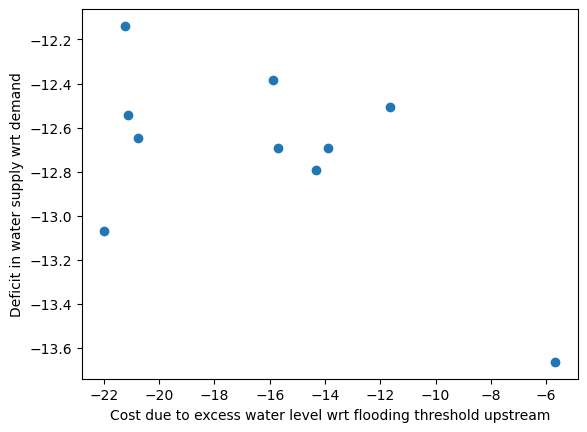

In [3]:
plot_pf('./noise5_decay_smallScaling.csv')

Returns are slightly worse than when using no decay and higher scaling factor.

Try to increase the scaling factor.

In [4]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True, noise=5.0)

max_return = np.zeros(2)

PCNAgent.train(10000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100,max_return=max_return)

wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/PCN
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in exp
  ent = np.sum(-np.exp(lp) * lp)
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in multiply
  ent = np.sum(-np.exp(lp) * lp)


step 60000 	 return [-77.6146  -87.56922], ([0.5192871 0.6546343]) 	 loss 9.284E+03
step 70000 	 return [-79.19106 -89.12555], ([0.52777964 0.6466042 ]) 	 loss 4.140E+03
step 80000 	 return [-74.47269  -84.399765], ([0.48488185 0.65345955]) 	 loss 3.139E+03
step 90000 	 return [-74.3658  -84.34794], ([0.49908277 0.6473662 ]) 	 loss 2.100E+03
step 100000 	 return [-71.752556 -81.65216 ], ([0.45104003 0.6160512 ]) 	 loss 1.039E+03
step 110000 	 return [-69.598465 -79.51743 ], ([0.4084645 0.5454903]) 	 loss 6.226E+02
step 120000 	 return [-69.39671 -79.31772], ([0.3759389  0.48656884]) 	 loss 4.678E+02
step 130000 	 return [-69.71568 -79.66215], ([0.38566944 0.51001245]) 	 loss 2.692E+02
step 140000 	 return [-69.19676 -79.08874], ([0.36429018 0.5444002 ]) 	 loss 1.739E+02


c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


step 150000 	 return [-69.14358  -79.078705], ([0.4138692  0.56714374]) 	 loss 7.440E+01
step 160000 	 return [-69.101036 -79.05263 ], ([0.29880813 0.42804167]) 	 loss 5.974E+01
step 170000 	 return [-68.29662 -78.26131], ([0.36749616 0.5238353 ]) 	 loss 5.018E+01
step 180000 	 return [-68.25035 -78.18594], ([0.29053345 0.4407057 ]) 	 loss 4.537E+01
step 190000 	 return [-67.23343 -77.1362 ], ([0.3269333  0.46278444]) 	 loss 4.116E+01
step 200000 	 return [-66.234085 -76.21499 ], ([0.3235398 0.4691497]) 	 loss 5.451E+01
step 210000 	 return [-67.78062 -77.70157], ([0.28520146 0.4232193 ]) 	 loss 6.207E+01
step 220000 	 return [-66.741936 -76.69667 ], ([0.2859972 0.4034878]) 	 loss 4.402E+01
step 230000 	 return [-66.68088 -76.59876], ([0.3151378  0.43456084]) 	 loss 6.111E+01
step 240000 	 return [-66.22589 -76.15383], ([0.3235377 0.4484442]) 	 loss 4.325E+01
step 250000 	 return [-66.70994 -76.64751], ([0.34231287 0.4435186 ]) 	 loss 4.400E+01
step 260000 	 return [-66.247475 -76.1615

c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


step 6740000 	 return [-19.344273 -29.16542 ], ([0.02072353 0.30655533]) 	 loss 4.032E-01
step 6750000 	 return [-19.334354 -29.13243 ], ([0.01785789 0.3399636 ]) 	 loss 3.620E-01
step 6760000 	 return [-19.332043 -29.106123], ([0.01281598 0.38035947]) 	 loss 3.924E-01
step 6770000 	 return [-19.341124 -29.095137], ([0.01064533 0.41202223]) 	 loss 3.455E-01
step 6780000 	 return [-19.31302  -29.085848], ([0.01523975 0.3603055 ]) 	 loss 5.684E-01
step 6790000 	 return [-19.32542  -29.118156], ([0.02134197 0.38380668]) 	 loss 5.049E-01
step 6800000 	 return [-19.310955 -29.105684], ([0.01754491 0.36859655]) 	 loss 6.311E-01
step 6810000 	 return [-19.297026 -29.132204], ([0.01759474 0.33058444]) 	 loss 4.948E-01
step 6820000 	 return [-19.301645 -29.13792 ], ([0.01278852 0.33218604]) 	 loss 4.073E-01
step 6830000 	 return [-19.263203 -29.051746], ([0.01723132 0.39374337]) 	 loss 4.814E-01
step 6840000 	 return [-19.260904 -28.978088], ([0.01590321 0.41768566]) 	 loss 4.255E-01
step 68500

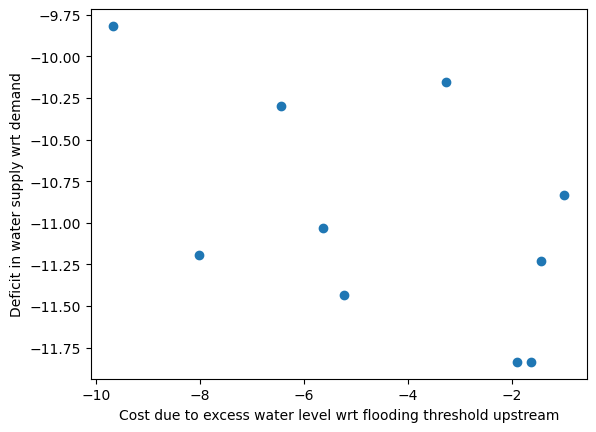

In [5]:
plot_pf('./noise5_decay.csv')

Using a scaling of 0.1 for the returns improves them by a significant amount, but there is still room for improvement if we want to reach the same performance as gpi...

Try to increase the scaling factor even more:

In [6]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.5, 0.5, 0.1), dtype=np.float32), continuous_actions=True, noise=5.0)

max_return = np.zeros(2)

PCNAgent.train(10000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100,max_return=max_return)

wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/PCN
c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in exp
  ent = np.sum(-np.exp(lp) * lp)
c:\Users\liamm\anaconda3\lib\site-packages\morl_baselines\multi_policy\pcn\pcn.py:411: RuntimeWarning: overflow encountered in multiply
  ent = np.sum(-np.exp(lp) * lp)


step 60000 	 return [-71.99667 -81.93241], ([0.43030995 0.5780136 ]) 	 loss 8.776E+03
step 70000 	 return [-78.04584 -87.99494], ([0.40900967 0.48895338]) 	 loss 4.281E+03
step 80000 	 return [-70.53062 -80.46731], ([0.30726284 0.4242694 ]) 	 loss 3.215E+03
step 90000 	 return [-66.817696 -76.75815 ], ([0.19571498 0.30260658]) 	 loss 2.205E+03
step 100000 	 return [-66.24229 -76.18389], ([0.17172727 0.29622653]) 	 loss 1.083E+03
step 110000 	 return [-66.680534 -76.64029 ], ([0.16138366 0.2657518 ]) 	 loss 5.077E+02
step 120000 	 return [-66.1188  -76.05401], ([0.14426862 0.21125801]) 	 loss 1.596E+02
step 130000 	 return [-65.635956 -75.53744 ], ([0.11425579 0.21633823]) 	 loss 8.232E+01
step 140000 	 return [-65.96396 -75.89455], ([0.14464469 0.20212756]) 	 loss 6.022E+01
step 150000 	 return [-65.7296  -75.67471], ([0.13864219 0.22043188]) 	 loss 4.015E+01
step 160000 	 return [-65.434715 -75.372215], ([0.14000195 0.21538502]) 	 loss 4.109E+01
step 170000 	 return [-65.223656 -75.18

c:\Users\liamm\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


step 3960000 	 return [-20.899832 -30.269175], ([0.7743384 0.7364228]) 	 loss 1.507E+01
step 3970000 	 return [-20.503695 -29.589487], ([1.586933   0.56272095]) 	 loss 2.017E+01
step 3980000 	 return [-21.044714 -30.010857], ([1.4560974  0.52648836]) 	 loss 2.641E+01
step 3990000 	 return [-19.922667 -29.628714], ([0.6197499  0.30386358]) 	 loss 2.228E+01
step 4000000 	 return [-20.47128  -29.675983], ([1.7102114 0.3779776]) 	 loss 1.892E+01
step 4010000 	 return [-19.712814 -29.375069], ([0.8613413  0.29407465]) 	 loss 1.637E+01
step 4020000 	 return [-19.111992 -28.773954], ([0.44662392 0.22884303]) 	 loss 1.343E+01
step 4030000 	 return [-19.474459 -28.66414 ], ([1.5914315  0.34207606]) 	 loss 1.418E+01
step 4040000 	 return [-18.398266 -28.097706], ([0.8736507  0.25267217]) 	 loss 1.475E+01
step 4050000 	 return [-18.180403 -27.775576], ([0.48586693 0.2651876 ]) 	 loss 1.417E+01
step 4060000 	 return [-18.625702 -27.978657], ([1.3721228  0.36383617]) 	 loss 1.368E+01
step 4070000 	

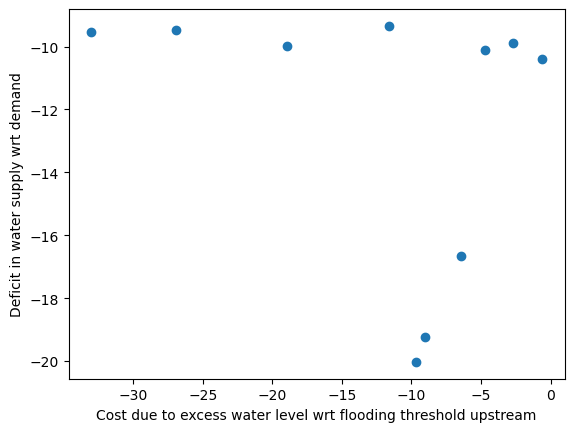

In [3]:
plot_pf('./noise5_decay_largeScaling.csv')